In [1]:
# Package that ensures a programatically interaction with operating system folder hierarchy.
from os import listdir

# Package used for clone a dictionary.
from copy import deepcopy

# Functions intended to extract some statistical parameters.
from numpy import max, std, average, sum, absolute

# With the following import we will be able to extract the linear regression parameters after
# fitting experimental points to the model.
from scipy.stats import linregress

# biosignalsnotebooks own package that supports some functionalities used on the Jupyter Notebooks.
import biosignalsnotebooks as bsnb

# Python package that contains functions specialized on "Machine Learning" tasks.
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV, RFE
from sklearn.preprocessing import normalize

from json import loads, dump

# Package containing a diversified set of function for statistical processing and also provide support to array operations.
from numpy import max, array

# Python package that contains functions specialized on "Machine Learning" tasks.
from sklearn.neighbors import KNeighborsClassifier

# Python package that contains functions specialised on "Machine Learning" tasks.
from sklearn.model_selection import cross_val_score, LeaveOneOut

import numpy as np

from scipy.stats import linregress

import os

import joblib

from scipy.stats import entropy
from scipy.signal import welch

In [ ]:
# Transposition of data from signal files to a Python dictionary.
data_folder = "data_1_and_2/"

# List of files (each file is a training example).
list_examples = listdir(data_folder)

In [3]:
# Initialization of dictionary.
signal_dict = {}

# Scrolling through each entry in the list.
for example in list_examples:
    if ".txt" in example: # Read only .txt files.
        # Get the class to which the training example under analysis belong.
        example_class = example.split("_")[0]

        # Get the trial number of the training example under analysis.
        example_trial = example.split("_")[1].split(".")[0]

        # Creation of a new "class" entry if it does not exist.
        if example_class not in signal_dict.keys():
            signal_dict[example_class] = {}

        # Load data.
        complete_data = bsnb.load(data_folder + "/" + example)

        # Store data in the dictionary.
        signal_dict[example_class][example_trial] = complete_data

In [4]:
# Channels (CH1 Flexor digitorum superficialis | CH2 Aductor policis | CH3 Accelerometer axis Z).
emg_flexor = "CH2"
emg_adductor = "CH4"
acc_z = "CH3"

In [5]:
# Clone "signal_dict".
features_dict = deepcopy(signal_dict)

# Navigate through "signal_dict" hierarchy.
list_classes = signal_dict.keys()
for class_i in list_classes:
    list_trials = signal_dict[class_i].keys()
    for trial in list_trials:
        # Initialise "features_dict" entry content.
        features_dict[class_i][trial] = []

        for chn in [emg_flexor, emg_adductor]: ################################# order
            # Temporary storage of signal inside a reusable variable.
            signal = signal_dict[class_i][trial][chn]

            # Start the feature extraction procedure accordingly to the channel under analysis.
            if chn == emg_flexor or chn == emg_adductor: # EMG Features.
                # Converted signal (taking into consideration that our device is a "biosignalsplux", the resolution is
                # equal to 16 bits and the output unit should be in "mV").
                signal = bsnb.raw_to_phy("EMG", device="biosignalsplux", raw_signal=signal, resolution=16, option="mV")

                # Standard Deviation.
                features_dict[class_i][trial] += [std(signal)]
                # Maximum Value.
                features_dict[class_i][trial] += [max(signal)]
                # Zero-Crossing Rate.
                features_dict[class_i][trial] += [sum([1 for i in range(1, len(signal)) 
                                                       if signal[i]*signal[i-1] <= 0]) / (len(signal) - 1)]
                # Standard Deviation of the absolute signal.
                features_dict[class_i][trial] += [std(absolute(signal))]

                wl = np.sum(np.abs(np.diff(signal)))  # waveform length
                wamp = np.sum(np.abs(np.diff(signal)) > 0.02)  # willison amplitude
                f, Pxx = welch(signal, fs=1000)
                spectral_centroid = np.sum(f * Pxx) / np.sum(Pxx)
                spectral_entropy = entropy(Pxx / np.sum(Pxx))
                
                features_dict[class_i][trial] += [wl]
                features_dict[class_i][trial] += [wamp]
                features_dict[class_i][trial] += [spectral_centroid]
                features_dict[class_i][trial] += [spectral_entropy]


            else: # ACC Features.
                # Converted signal (taking into consideration that our device is a "biosignalsplux", the resolution is
                # equal to 16 bits and the output unit should be in "g").
                signal = bsnb.raw_to_phy("ACC", device="biosignalsplux", raw_signal=signal, resolution=16, option="g")

                # Average value.
                features_dict[class_i][trial] += [average(signal)]
                # Standard Deviation.
                features_dict[class_i][trial] += [std(signal)]
                # Maximum Value.
                features_dict[class_i][trial] += [max(signal)]
                # Zero-Crossing Rate.
                features_dict[class_i][trial] += [sum([1 for i in range(1, len(signal)) 
                                                       if signal[i]*signal[i-1] <= 0]) / (len(signal) - 1)]
                # Slope of the regression curve.
                x_axis = range(0, len(signal))
                features_dict[class_i][trial] += [linregress(x_axis, signal)[0]]

In [6]:
from sty import fg, rs
print(fg(98,195,238) + "\033[1mDict Keys\033[0m" + fg.rs + " define the class number")
print(fg(232,77,14) + "\033[1mDict Sub-Keys\033[0m" + fg.rs + " define the trial number\n")
print(features_dict)

Dict Keys define the class number
Dict Sub-Keys define the trial number

{'1': {'3': [0.0018116347807403438, -1.453216552734375, 0.0, 0.0018116347807403438, 4.440582275390625, 2, 115.72976922081092, 3.999642694862737, 1.9141502847591157e-05, -1.4767913818359375, 0.0, 1.9141502847591157e-05, 0.0780029296875, 0, 232.54655049655764, 4.655399931972259], '4': [0.0012019167309204686, -1.4626922607421875, 0.0, 0.0012019167309204686, 3.382598876953125, 0, 115.17589930770025, 4.096158092876865, 2.1117077786380792e-05, -1.4767913818359375, 0.0, 2.1117077786380792e-05, 0.0933380126953125, 0, 239.89274271971198, 4.642209252980391], '11': [0.0016093366932819135, -1.4690093994140625, 0.0, 0.0016093366932819135, 4.5189056396484375, 0, 102.2870175795733, 3.6161732692025574, 0.002026646797614914, -1.4632415771484375, 0.0, 0.002026646797614914, 5.780181884765625, 0, 101.56172583644494, 3.638600125001754], '2': [0.0012319227810117907, -1.460540771484375, 0.0, 0.0012319227810117907, 4.017425537109375, 0, 

In [7]:
# Initialisation of a list containing our training data and another list containing the labels of each training example.
features_list = []
class_training_examples = []

# Access each feature list inside dictionary.
list_classes = features_dict.keys()
# for class_i in list_classes:
for class_i in sorted(signal_dict.keys(), key=lambda x: int(x)):
    list_trials = features_dict[class_i].keys()
    for trial in list_trials:
        # Storage of the class label.
        class_training_examples += [int(class_i)]
        features_list += [features_dict[class_i][trial]]

print(fg(232,77,14) + "\033[1m[Number of list entries;Number of sub-list entries]:\033[0m" + fg.rs + " [" + str(len(features_list)) + "; " + str(len(features_list[0])) + "]" + u'\u2713')
print(fg(253,196,0) + "\033[1mClass of each training example:\033[0m" + fg.rs)
print(class_training_examples)
print(fg(98,195,238) + "\033[1mFeatures List:\033[0m" + fg.rs)
print(features_list)

[Number of list entries;Number of sub-list entries]: [60; 16]✓
Class of each training example:
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
Features List:
[[0.0001229975705213289, -1.4761962890625, 0.0, 0.0001229975705213289, 0.430572509765625, 0, 109.24958060443396, 3.1617432272731816, 1.9267049076378422e-05, -1.4767913818359375, 0.0, 1.9267049076378422e-05, 0.0816650390625, 0, 235.084395436689, 4.648567905167228], [0.001888749851487402, -1.471435546875, 0.0, 0.001888749851487402, 4.08050537109375, 0, 68.73763140447468, 2.010190449409936, 0.002420444541542135, -1.46905517578125, 0.0, 0.002420444541542135, 5.541778564453125, 0, 72.97869997421941, 2.2226017888734777], [0.0018730107279399124, -1.471435546875, 0.0, 0.0018730107279399124, 3.560577392578125, 0, 67.14032021166771, 2.0235411221116624, 0.0023338192299834364, -1.4669952392578125, 0.0, 0.0023338

In [8]:
feature_list_notnormalized = deepcopy(features_list)
max_per_feature = np.max(feature_list_notnormalized, axis=0)
np.save("model/max_per_feature.npy", max_per_feature)

# features_list = normalize(features_list, axis=0, norm="max") # axis=0 specifies that each feature is normalised independently from the others
# and norm="max" defines that the normalization reference value will be the feature maximum value.

features_list = features_list / (max_per_feature + 1e-12)

In [9]:
# Creation of a "Support Vector Classifier" supposing that  our classes are linearly separable.
svc = SVC(kernel="linear")
rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(5), scoring='accuracy')
# Fit data to the model.
selector = rfecv.fit(features_list, class_training_examples)
# Get list of average score of the virtual classifier
# avg_scores = rfecv.grid_scores_
avg_scores = rfecv.cv_results_['mean_test_score']
print(avg_scores)
max_score = max(avg_scores)
print(fg(98,195,238) + "\033[1mMaximum Average Score:\033[0m " + fg.rs + str(max_score))
for nbr_features in range(0, len(avg_scores)):
    if avg_scores[nbr_features] == max_score:
        optimal_nbr_features = nbr_features + 1
        break
print(fg(98,195,238) + "\033[1mOptimal Number of Features:\033[0m " + fg.rs + str(optimal_nbr_features))
bsnb.plot([range(1, len(rfecv.cv_results_['mean_test_score']) + 1)], [avg_scores], 
          y_axis_label="Cross validation score (nb of correct classifications)", x_axis_label="Number of features selected")

[0.51666667 0.5        0.45       0.43333333 0.53333333 0.51666667
 0.48333333 0.48333333 0.48333333 0.46666667 0.46666667 0.46666667
 0.46666667 0.46666667 0.46666667 0.46666667]
Maximum Average Score: 0.5333333333333333
Optimal Number of Features: 5


In [10]:
rfe = RFE(estimator=svc, step=1, n_features_to_select=optimal_nbr_features)

# Fit data to the model.
final_selector = rfe.fit(features_list, class_training_examples)

# Acception/Rejection Label attributed to each feature.
acception_labels = final_selector.support_


print(fg(98,195,238) + "\033[1mRelevant Features (True):\033[0m " + fg.rs)
print(acception_labels)


####################### SELECT HERE #########################
acception_labels = acception_labels

print()
print(fg(98, 195, 238) + "\033[1mUsed Features Mask:\033[0m " + fg.rs)
print(acception_labels)

np.save("model/acception_labels.npy", acception_labels)
print("✅ Saved feature mask to acception_labels.npy")

Relevant Features (True): 
[ True False False  True  True False False  True False False False False
  True False False False]

Used Features Mask: 
[ True False False  True  True False False  True False False False False
  True False False False]
✅ Saved feature mask to acception_labels.npy


In [11]:
# Access each training example and exclude meaningless entries.
final_features_list = []
print(features_list.shape)
for example_nbr in range(0, len(features_list)):
    final_features_list += [
        list(array(features_list[example_nbr])[array(acception_labels)])
    ]

(60, 16)


In [12]:
filename_final = "classification_game_features_final.json"

features_dict_final = {
    "features_list_final": final_features_list,
    "class_labels": class_training_examples,
}

from sty import fg, rs
print(fg(98,195,238) + "\033[1mDict Keys\033[0m" + fg.rs + " divides training example in its features and class label")
print(features_dict_final)

Dict Keys divides training example in its features and class label
{'features_list_final': [[0.019357833378569146, 0.019357833378569146, 0.030444563124077405, 0.7451665965750381, 0.004288739674225955], [0.29725875693252124, 0.29725875693252124, 0.28852098202001486, 0.47376610558799953, 0.29103329733247907], [0.2947816727928456, 0.2947816727928456, 0.2517583466847745, 0.4769126214888852, 0.24545341828353057], [0.30271911789789946, 0.30271911789789946, 0.2859154245763744, 0.4714742775690923, 0.2782512183818852], [0.1535794256437224, 0.1535794256437224, 0.19864381544236429, 0.9693571109649887, 0.004555583902835306], [0.18981769124961784, 0.18981769124961784, 0.21262967098766924, 0.7235124787176672, 0.2065710889724708], [0.21184306553905358, 0.21184306553905358, 0.24766713599066073, 0.6493494364827614, 0.22550020118931788], [0.3007588653988852, 0.3007588653988852, 0.2819892864656466, 0.4757554728464104, 0.27513803571477613], [0.019295580008909463, 0.019295580008909463, 0.041944619766629714

KNN

In [13]:
training_examples = features_dict_final["features_list_final"]
class_training_examples = features_dict_final["class_labels"]

# k-Nearest Neighbour object initialisation.
knn_classifier = KNeighborsClassifier()

knn_classifier.fit(training_examples, class_training_examples)

joblib.dump(knn_classifier, "model/knn_classifier.pkl")

print(training_examples)

print("Training data shape:", np.array(training_examples).shape)

[[0.019357833378569146, 0.019357833378569146, 0.030444563124077405, 0.7451665965750381, 0.004288739674225955], [0.29725875693252124, 0.29725875693252124, 0.28852098202001486, 0.47376610558799953, 0.29103329733247907], [0.2947816727928456, 0.2947816727928456, 0.2517583466847745, 0.4769126214888852, 0.24545341828353057], [0.30271911789789946, 0.30271911789789946, 0.2859154245763744, 0.4714742775690923, 0.2782512183818852], [0.1535794256437224, 0.1535794256437224, 0.19864381544236429, 0.9693571109649887, 0.004555583902835306], [0.18981769124961784, 0.18981769124961784, 0.21262967098766924, 0.7235124787176672, 0.2065710889724708], [0.21184306553905358, 0.21184306553905358, 0.24766713599066073, 0.6493494364827614, 0.22550020118931788], [0.3007588653988852, 0.3007588653988852, 0.2819892864656466, 0.4757554728464104, 0.27513803571477613], [0.019295580008909463, 0.019295580008909463, 0.041944619766629714, 0.861944867627211, 0.005558052761665028], [0.02256165381646965, 0.02256165381646965, 0.03

In [14]:
# import numpy as np
# from numpy import array

# from bokeh.layouts import layout
# from bokeh.models import CustomJS, Slider, Select, ColumnDataSource, WidgetBox
# from bokeh.plotting import figure, show

# tools = 'pan'
# features_identifiers = ["std_emg_flexor", "zcr_emg_flexor", "std_abs_emg_flexor", "std_emg_adductor", "std_abs_emg_adductor", "std_acc_z", "max_acc_z", "m_acc_z"]

# def slider():
#     dict_features = {}
#     for feature_nbr in range(0, len(training_examples[0])):
#         values_feature = array(training_examples)[:, feature_nbr]
        
#         # Fill of dict.
#         for class_of_example in range(0, len(class_training_examples)):
#             current_keys = list(dict_features.keys())
#             if class_training_examples[class_of_example] not in current_keys:
#                 dict_features[class_training_examples[class_of_example]] = {}
            
#             current_sub_keys = list(dict_features[class_training_examples[class_of_example]].keys())
#             if features_identifiers[feature_nbr] not in current_sub_keys:
#                 dict_features[class_training_examples[class_of_example]][features_identifiers[feature_nbr]] = []
            
#             dict_features[class_training_examples[class_of_example]][features_identifiers[feature_nbr]] += [values_feature[class_of_example]]
            
#             # Add of two additional keys that will store the data currently being ploted.
#             if feature_nbr == 0:
#                 if "x" not in current_sub_keys:
#                     dict_features[class_training_examples[class_of_example]]["x"] = []
#                 dict_features[class_training_examples[class_of_example]]["x"] += [values_feature[class_of_example]]
#             elif feature_nbr == 1:
#                 if "y" not in current_sub_keys:
#                     dict_features[class_training_examples[class_of_example]]["y"] = []
#                 dict_features[class_training_examples[class_of_example]]["y"] += [values_feature[class_of_example]]
        
#     source_class_0 = ColumnDataSource(data=dict_features[0])
#     source_class_1 = ColumnDataSource(data=dict_features[1])
#     source_class_2 = ColumnDataSource(data=dict_features[2])
#     source_class_3 = ColumnDataSource(data=dict_features[3])

#     plot = figure(x_range=(-1.5, 1.5), y_range=(-1.5, 1.5), tools='', toolbar_location=None, title="Pairing Classification Dimensions")
#     bsnb.opensignals_style([plot])
    
#     # Define different colours for points of each class.
#     # [Class 0]
#     plot.circle('x', 'y', source=source_class_0, line_width=3, line_alpha=0.6, color="red")
#     # [Class 1]
#     plot.circle('x', 'y', source=source_class_1, line_width=3, line_alpha=0.6, color="green")
#     # [Class 2]
#     plot.circle('x', 'y', source=source_class_2, line_width=3, line_alpha=0.6, color="orange")
#     # [Class 3]
#     plot.circle('x', 'y', source=source_class_3, line_width=3, line_alpha=0.6, color="blue")

#     callback = CustomJS(args=dict(source=[source_class_0, source_class_1, source_class_2, source_class_3]), code="""
#         // Each class has an independent data structure.
#         var data_0 = source[0].data;
#         var data_1 = source[1].data;
#         var data_2 = source[2].data;
#         var data_3 = source[3].data;
        
#         // Selected values in the interface.
#         var feature_identifier_x = x_feature.value;
#         var feature_identifier_y = y_feature.value;
#         console.log("x_feature: " + feature_identifier_x);
#         console.log("y_feature: " + feature_identifier_y);
        
#         // Update of values.
#         var x_0 = data_0["x"];
#         var y_0 = data_0["y"];
#         for (var i = 0; i < x_0.length; i++) {
#             x_0[i] = data_0[feature_identifier_x][i];
#             y_0[i] = data_0[feature_identifier_y][i];
#         }
        
#         var x_1 = data_1["x"];
#         var y_1 = data_1["y"];
#         for (var i = 0; i < x_1.length; i++) {
#             x_1[i] = data_1[feature_identifier_x][i];
#             y_1[i] = data_1[feature_identifier_y][i];
#         }
        
#         var x_2 = data_2["x"];
#         var y_2 = data_2["y"];
#         for (var i = 0; i < x_2.length; i++) {
#             x_2[i] = data_2[feature_identifier_x][i];
#             y_2[i] = data_2[feature_identifier_y][i];
#         }
        
#         var x_3 = data_3["x"];
#         var y_3 = data_3["y"];
#         for (var i = 0; i < x_3.length; i++) {
#             x_3[i] = data_3[feature_identifier_x][i];
#             y_3[i] = data_3[feature_identifier_y][i];
#         }
        
#         // Communicate update.
#         source[0].change.emit();
#         source[1].change.emit();
#         source[2].change.emit();
#         source[3].change.emit();
#     """)

#     # x_feature_select = Select(title="Select the Feature of Axis x:", value="std_emg_flexor", options=features_identifiers, callback=callback)
#     # callback.args["x_feature"] = x_feature_select
    
#     # y_feature_select = Select(title="Select the Feature of Axis y:", value="zcr_emg_flexor", options=features_identifiers, callback=callback)
#     # callback.args["y_feature"] = y_feature_select

#     x_feature_select = Select(
#         title="Select the Feature of Axis x:",
#         value="std_emg_flexor",
#         options=features_identifiers
#     )
#     y_feature_select = Select(
#         title="Select the Feature of Axis y:",
#         value="zcr_emg_flexor",
#         options=features_identifiers
#     )

#     # Register your callback properly using js_on_change()
#     callback.args["x_feature"] = x_feature_select
#     callback.args["y_feature"] = y_feature_select

#     x_feature_select.js_on_change("value", callback)
#     y_feature_select.js_on_change("value", callback)

#     widgets = WidgetBox(x_feature_select, y_feature_select)
#     return [widgets, plot]

# l = layout([slider(),], sizing_mode='scale_width')

# show(l)

In [15]:
leave_one_out_score_a = cross_val_score(knn_classifier, training_examples, class_training_examples, scoring="accuracy", cv=LeaveOneOut())

# Average accuracy of classifier.
mean_l1o_score_a = leave_one_out_score_a.mean()

# Standard Deviation of the previous estimate.
std_l1o_score_a = leave_one_out_score_a.std()

y_train_pred = knn_classifier.predict(training_examples)
accuracy = np.mean(y_train_pred == class_training_examples)
print("Training accuracy:", accuracy)

from sty import fg, rs

print(fg(232, 77, 14) + "\033[1mAverage Accuracy of Classifier:\033[0m" + fg.rs)
print(str(mean_l1o_score_a * 100) + " %")

print(fg(98, 195, 238) + "\033[1mStandard Deviation:\033[0m" + fg.rs)
print("+-" + str(round(std_l1o_score_a, 1) * 100) + " %")

Training accuracy: 0.75
Average Accuracy of Classifier:
56.666666666666664 %
Standard Deviation:
+-50.0 %


File: 0_1.txt    → Predicted Class: 0
File: 0_10.txt   → Predicted Class: 0
File: 0_11.txt   → Predicted Class: 0
File: 0_12.txt   → Predicted Class: 1
File: 0_13.txt   → Predicted Class: 0
File: 0_14.txt   → Predicted Class: 0
File: 0_15.txt   → Predicted Class: 0
File: 0_2.txt    → Predicted Class: 3
File: 0_3.txt    → Predicted Class: 0
File: 0_4.txt    → Predicted Class: 0
File: 0_5.txt    → Predicted Class: 0
File: 0_6.txt    → Predicted Class: 0
File: 0_7.txt    → Predicted Class: 0
File: 0_8.txt    → Predicted Class: 0
File: 0_9.txt    → Predicted Class: 0
File: 1_1.txt    → Predicted Class: 1
File: 1_10.txt   → Predicted Class: 0
File: 1_11.txt   → Predicted Class: 1
File: 1_12.txt   → Predicted Class: 1
File: 1_13.txt   → Predicted Class: 1
File: 1_14.txt   → Predicted Class: 0
File: 1_15.txt   → Predicted Class: 0
File: 1_2.txt    → Predicted Class: 1
File: 1_3.txt    → Predicted Class: 1
File: 1_4.txt    → Predicted Class: 3
File: 1_5.txt    → Predicted Class: 3
File: 1_6.tx

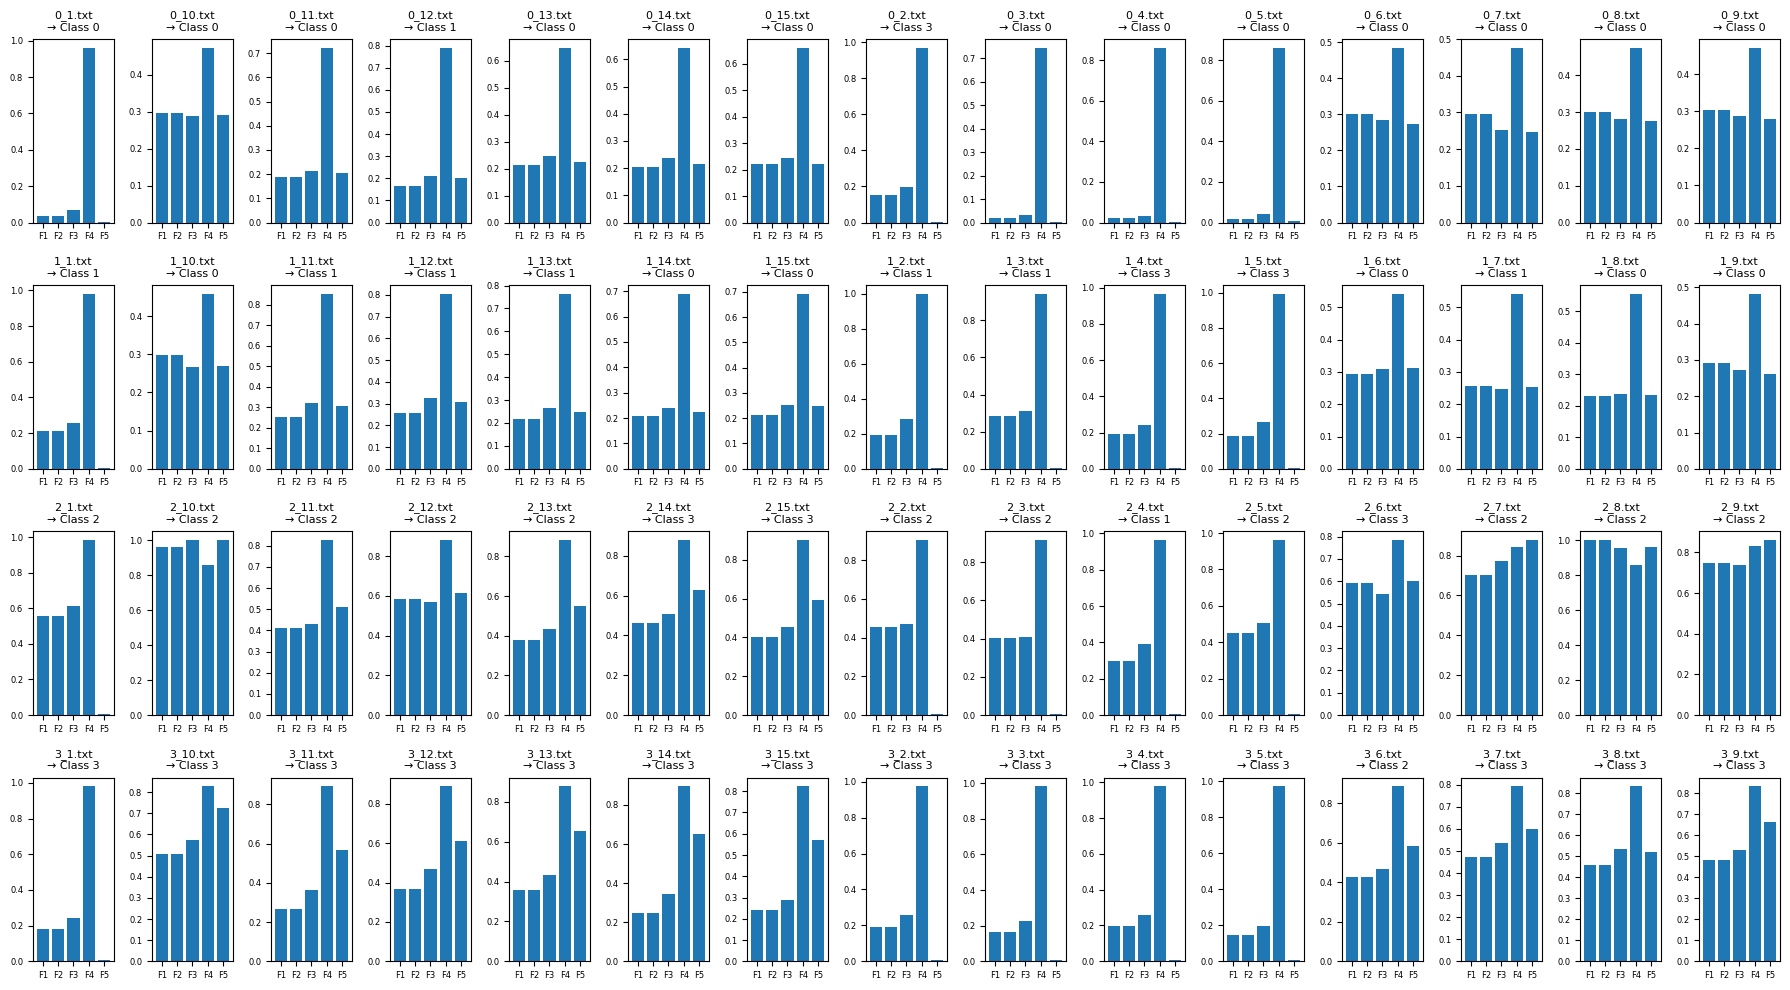

In [16]:
import matplotlib.pyplot as plt

# --- Feature extraction for one recording ---
def extract_features(signal):
    """
    Extract the same 13 features as in training
    from one raw signal recording (.txt).
    """
    #####################
    emg_flexor_channel = 2 + 4
    emg_adductor_channel = 4 + 4
    acc_channel = 3 + 4

    signal = np.array(signal)

    # Ensure correct shape (n_samples, n_channels)
    if signal.ndim == 1:
        signal = signal.reshape(-1, 1)

    # Split channels
    emg_flexor = signal[:, emg_flexor_channel]  
    emg_adductor = signal[:, emg_adductor_channel] 
    acc_z = signal[:, acc_channel]

    # --- Convert raw to physical units
    emg_flexor_conv = bsnb.raw_to_phy("EMG", device="biosignalsplux", raw_signal=emg_flexor, resolution=16, option="mV")
    emg_adductor_conv = bsnb.raw_to_phy("EMG", device="biosignalsplux", raw_signal=emg_adductor, resolution=16, option="mV")
    acc_z_conv = bsnb.raw_to_phy("ACC", device="biosignalsplux", raw_signal=acc_z, resolution=16, option="g")

    features_emg_flexor = []
    features_emg_adductor = []
    for emg_signal in [emg_flexor_conv, emg_adductor_conv]:
        sigma_emg = np.std(emg_signal)
        max_emg = np.max(emg_signal)
        zcr_emg = np.sum(np.diff(np.sign(emg_signal)) != 0) / len(emg_signal)
        sigma_abs_emg = np.std(np.abs(emg_signal))

        wl = np.sum(np.abs(np.diff(emg_signal)))  # waveform length
        wamp = np.sum(np.abs(np.diff(emg_signal)) > 0.02)  # willison amplitude
        f, Pxx = welch(emg_signal, fs=1000)
        spectral_centroid = np.sum(f * Pxx) / np.sum(Pxx)
        spectral_entropy = entropy(Pxx / np.sum(Pxx))

        if emg_signal is emg_flexor_conv:
            features_emg_flexor += [sigma_emg, max_emg, zcr_emg, sigma_abs_emg, wl, wamp, spectral_centroid, spectral_entropy]
        if emg_signal is emg_adductor_conv:
            features_emg_adductor += [sigma_emg, max_emg, zcr_emg, sigma_abs_emg, wl, wamp, spectral_centroid, spectral_entropy]

    # --- Accelerometer Z ---
    features_acc = []
    m_acc_z = np.mean(acc_z_conv)
    sigma_acc_z = np.std(acc_z_conv)
    max_acc_z = np.max(acc_z_conv)
    zcr_acc_z = np.sum(np.diff(np.sign(acc_z_conv)) != 0) / len(acc_z_conv)
    # slope_acc_z = linregress(np.arange(len(acc_z_conv)), acc_z_conv)[0]
    x_axis = range(0, len(acc_z_conv))
    slope_acc_z = linregress(x_axis, acc_z_conv)[0]
    features_acc += [m_acc_z, sigma_acc_z, max_acc_z, zcr_acc_z, slope_acc_z]

    # --- Combine all into one 13-feature vector ---
    features_13 = np.concatenate([features_emg_flexor, features_emg_adductor])

    max_per_feature = np.load("model/max_per_feature.npy")
    # Compute the same scaling factors used in training
    normalized_features_13 = features_13 / (max_per_feature + 1e-12)

    return normalized_features_13


def classify_new_recording(filepath, classifier, feature_mask):
    """
    Reads one file, extracts features, selects the 8 important ones,
    and classifies with a trained model.
    """
    # Load raw signal
    signal = np.loadtxt(filepath)

    # Extract all 13 features
    full_features = extract_features(signal)

    # Select only the 8 relevant features
    reduced_features = np.array(full_features)[feature_mask]

    pred = classifier.predict([reduced_features])[0]

    return reduced_features, pred


def classify_all_in_folder(data_folder, classifier, feature_mask=acception_labels):
    """Classify all .txt files in the given folder."""
    results = []
    files = sorted([f for f in os.listdir(data_folder) if f.endswith(".txt")])

    # --- Prepare the figure with subplots ---
    n_cols = 15
    n_rows = 4
    total_plots = n_cols * n_rows
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 10))
    axes = axes.flatten()

    for idx, fname in enumerate(files[:total_plots]):  # Limit to 20 plots
        fpath = os.path.join(data_folder, fname)
        try:
            reduced_features, pred = classify_new_recording(
                fpath, classifier, feature_mask
            )
            results.append((fname, pred))

            print(f"File: {fname:<10} → Predicted Class: {pred}")

            ax = axes[idx]
            ax.bar(range(len(reduced_features)), reduced_features)
            ax.set_title(f"{fname}\n→ Class {pred}", fontsize=8)
            ax.set_xticks(range(len(reduced_features)))
            ax.set_xticklabels(
                [f"F{i+1}" for i in range(len(reduced_features))], fontsize=6
            )
            ax.tick_params(axis="y", labelsize=6)

        except Exception as e:
            print(f"⚠️ Error processing {fname}: {e}")

    # Hide empty subplots
    for j in range(len(files), total_plots):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

    return results


data_folder = "/home/ferdinand/realworld_interact_systems/data2"
results = classify_all_in_folder(data_folder, knn_classifier)

# pred = classify_new_recording("/home/ferdinand/realworld_interact_systems/data/0_1.txt", knn_classifier_a)
# print("Predicted class:", pred)

In [17]:
# Suppose X_train[i] was used in training with label y_train[i]
import numpy as np

file = "/home/ferdinand/realworld_interact_systems/data2/0_1.txt"

f_new, pred_new = classify_new_recording(file, knn_classifier, acception_labels)

print("Model predicted:", pred_new)
print("Training label:", class_training_examples[0])
print("Extracted features (current code):", np.round(f_new, 3))
print("Training features (original X_train row):", np.round(training_examples[0], 3))

Model predicted: 0
Training label: 0
Extracted features (current code): [0.035 0.035 0.068 0.963 0.003]
Training features (original X_train row): [0.019 0.019 0.03  0.745 0.004]


In [18]:
max_per_feature = np.load("model/max_per_feature.npy")
print("max_per_feature shape:", max_per_feature.shape)
print("max_per_feature values:", max_per_feature)

max_per_feature shape: (16,)
max_per_feature values: [ 6.35389137e-03 -1.45321655e+00  0.00000000e+00  6.35389137e-03
  1.41428375e+01  2.30000000e+01  1.35369801e+02  4.24300182e+00
  6.58284912e-03 -1.45321655e+00  0.00000000e+00  6.58284912e-03
  1.90417338e+01  2.90000000e+01  2.44268908e+02  4.71370434e+00]
